# `ScatterBatch` muon filtering

Let's try to understand at which step the muons are removed.

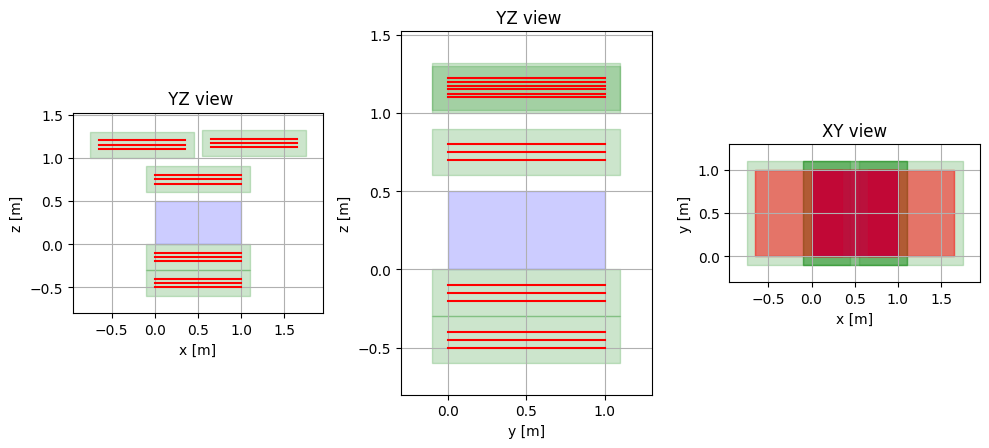

In [7]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume.layer import PassiveLayer
from tomopt.core import DEVICE
from tomopt.volume import Volume
from torch import nn
import torch
from torch import Tensor

def get_z_overlap_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1.2, 1.2, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e5

    hods = [Hodoscope(init_xyz= [0.5, 0.5, .9], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res), 
            Hodoscope(init_xyz= [1.15, .5, 1.32], 
            init_xyz_span = init_xyz_span, 
            xyz_gap = xyz_gap, 
            eff = init_eff,
            res = init_res), 
                      Hodoscope(init_xyz= [-.15, .5, 1.3], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res),
                      ]
                    #  ) for xy, z in zip([0.4, 0.8], [.9, 1.3])]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0.0,-0.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))

# Create the volume
volume = get_z_overlap_hod_config()

# Draw volume
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

from tomopt.muon import MuonGenerator2016, MuonBatch
from tomopt.inference.scattering import ScatterBatch

# generate muons
gen = MuonGenerator2016(x_range=[0.,1.], y_range=[0.,1.], theta_range=[0.001, 0.2], energy_range=[1.,4.])
muons = MuonBatch(xy_p_theta_phi=gen.generate_set(500), init_z = 1.5)

# Set training to false 
for l in volume.layers:
    if isinstance(l, HodoscopeDetectorLayer):
        for h in l.hodoscopes:
            for p in h.panels:
                p.training = False

In [8]:
# Manually propagate muons through detector layers
for l in volume.layers:
    if isinstance(l, HodoscopeDetectorLayer):
        for i, p in l.yield_zordered_panels():
            # print("Panel {}".format(i))
            muons.propagate_dz(muons.z - p.z.detach())  # Move to panel
            hits = p.get_hits(muons)
            # print("hits = ", hits["reco_xyz"])
            muons.append_hits(hits, l.pos)


In [9]:
muons.get_hits()['above']['reco_xyz']

tensor([[[0.7526, 0.3642, 1.2200],
         [  -inf,    inf, 1.2000],
         [0.7614, 0.3604, 1.1700],
         ...,
         [0.8262, 0.3324, 0.8000],
         [0.8349, 0.3286, 0.7500],
         [0.8437, 0.3248, 0.7000]],

        [[   inf,   -inf, 1.2200],
         [0.2128, 0.8508, 1.2000],
         [   inf,    inf, 1.1700],
         ...,
         [0.2639, 0.8828, 0.8000],
         [0.2703, 0.8868, 0.7500],
         [0.2767, 0.8907, 0.7000]],

        [[  -inf,    inf, 1.2200],
         [0.1700, 0.5870, 1.2000],
         [   inf,   -inf, 1.1700],
         ...,
         [0.2191, 0.6208, 0.8000],
         [0.2252, 0.6250, 0.7500],
         [0.2313, 0.6292, 0.7000]],

        ...,

        [[   inf,    inf, 1.2200],
         [0.1197, 0.3852, 1.2000],
         [  -inf,   -inf, 1.1700],
         ...,
         [0.1415, 0.3674, 0.8000],
         [0.1442, 0.3652, 0.7500],
         [0.1470, 0.3630, 0.7000]],

        [[0.9267, 0.5595, 1.2200],
         [   inf,   -inf, 1.2000],
         [0.

At this stage, muons outside of the panels have NaNs as `xy` coordinate, but are still present in the `MuonBatch`.

Let's instanciate the `ScatterBatch` class, with the `MuonBatch`:

In [10]:
sb = ScatterBatch(mu = muons, volume = volume)

before unc n_muons =  tensor(174)
n_muons =  tensor(0)


In [11]:
sb._gen_hits, sb._reco_hits

(tensor([], size=(0, 15, 3), grad_fn=<CatBackward0>),
 tensor([], size=(0, 15, 3), grad_fn=<CatBackward0>))

Once the scatter batch is instanciated, muons containing NaNs have been removed.

The `__init__()` method of the `ScatterBatch` class is implemented as follow:

```python
self.mu, self.volume = mu, volume
    self.device = self.mu.device
    self._hits = self.mu.get_hits()
    self._compute_scatters()
```

After further investigations it appears that the muons are removed during `self._compute_scatters()`.

```python
def _compute_scatters(self) -> None:
    self._extract_hits()
    self._compute_tracks()
    self._filter_scatters()
```


The `_filer_scatter()` method is responsible for filtering the muons. It proceeds to the following cuts:

 - Remove muons with $d\theta = 0$.
 - Remove muons with tracks parallel to volume.
 - Remove muons with tracks entering or exiting far from the volume.
 - Remove muons with high uncertainties

After counting the number of rejected events at the each or each step, it seems that events are removed because of the high uncertainty of certain hits `hits_uncs`. This will happen pretty often when working with side by side hodoscopes configurations: each muon will not traverse each hodoscopes which results in high `hits_uncs`.

For `panel.training = False` mode, we should only keep the hits with non NaNs `hits_unc`.

The problem is that `MuonBatch._hits()` are stored as `Dict` with a structure that follows the total number of planes. Instead, we would need to have a more flexible data structure, that might change from one event to another.

We need to have hits data structure with size (nmuons, hits, 3) where hits can change from one event to another.